# CAP 4611: Homework 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.linear_model as linmod

## Part I - Data Exploration
Here, we will look into some of the specifics of the dataset. Before that, however, we must first import the data.

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
new_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "iris_class"]
dataset = pd.read_csv(url, names=new_names)
# This randomizes the dataset per HW1 specifications (mainly for part II)
dataset = dataset.sample(frac=1,random_state=123).reset_index(drop=True)
# Prints out the dataset
print(dataset)

     sepal_length  sepal_width  petal_length  petal_width       iris_class
0             6.3          2.5           4.9          1.5  Iris-versicolor
1             6.8          3.0           5.5          2.1   Iris-virginica
2             6.4          2.8           5.6          2.2   Iris-virginica
3             5.6          3.0           4.1          1.3  Iris-versicolor
4             4.9          3.1           1.5          0.1      Iris-setosa
..            ...          ...           ...          ...              ...
145           5.1          3.5           1.4          0.3      Iris-setosa
146           5.1          2.5           3.0          1.1  Iris-versicolor
147           5.6          3.0           4.5          1.5  Iris-versicolor
148           6.2          2.8           4.8          1.8   Iris-virginica
149           7.2          3.6           6.1          2.5   Iris-virginica

[150 rows x 5 columns]


### A. Number of Classes and Balancing
This will get the unique classes and save them to a list.

In [ ]:
classes = dataset['iris_class'].unique()
class_cnt = len(classes)
print(classes)
print('Number of classes: ' + str(class_cnt))

['Iris-versicolor' 'Iris-virginica' 'Iris-setosa']
Number of classes: 3


Let's test whether if this dataset is _balanced_ or _unbalanced_.

In [ ]:
num_examples = dataset['iris_class'].value_counts()
print(num_examples)

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: iris_class, dtype: int64


This is indicative of a _balanced_ dataset. As the number of examples for each class match very closely (in this case, exactly), the training will not have an immediate bias towards or against any class based on example count.

### B. Extremes of Features
Next, let's get a better look at some of the features of the flowers. We will find the extremes of each feature (min and max value).

In [ ]:
# Sepal Length
print("Min sepal length = {0} in.".format(dataset['sepal_length'].min()))
print("Max sepal length = {0} in.\n".format(dataset['sepal_length'].max()))
# Sepal Width
print("Min sepal width = {0} in.".format(dataset['sepal_width'].min()))
print("Max sepal width = {0} in.\n".format(dataset['sepal_width'].max()))
# Petal Length
print("Min petal length = {0} in.".format(dataset['petal_length'].min()))
print("Max petal length = {0} in.\n".format(dataset['petal_length'].max()))
# Petal Width
print("Min petal width = {0} in.".format(dataset['petal_width'].min()))
print("Max petal width = {0} in.".format(dataset['petal_width'].max()))

Min sepal length = 4.3 in.
Max sepal length = 7.9 in.

Min sepal width = 2.0 in.
Max sepal width = 4.4 in.

Min petal length = 1.0 in.
Max petal length = 6.9 in.

Min petal width = 0.1 in.
Max petal width = 2.5 in.


### C. Scatterplots
Let's get a better look at the sepal lengths/widths and the petal lengths/widths through the use of a scatterplot.

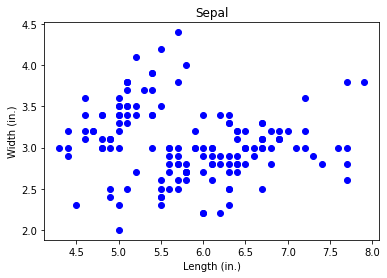

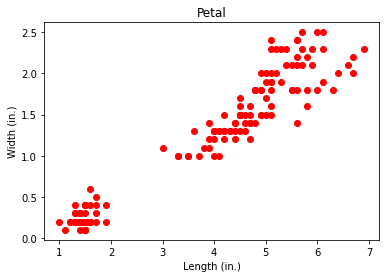

In [ ]:
def scatterplot_data(x, features, label, c):
  x_feat_l = x[:,features[0]]
  x_feat_w = x[:,features[1]]
  plt.scatter(x_feat_l, x_feat_w, c=c)
  plt.title('{0}'.format(label))
  plt.xlabel('Length (in.)')
  plt.ylabel('Width (in.)')
  plt.show()
  return

np_dataset = dataset.values
scatterplot_data(np_dataset, [0,1], 'Sepal', 'blue')
scatterplot_data(np_dataset, [2,3], 'Petal', 'red')

### D. Linear Regression
We can now train a linear regression model to show the relation between width and length for sepals and petals. As seen above, it is expected for the petal's l/w to be much more closely related than sepal's (petal r^2 score ≈ 1, whereas sepal r^2 score ≈ 0).

In [ ]:
# Train relationship for sepal
sepal_l_reshape = np_dataset[:,0].reshape(-1,1)
sepal_w_reshape = np_dataset[:,1].reshape(-1,1)
a = linmod.LinearRegression().fit(sepal_l_reshape,sepal_w_reshape)
# Train relationship for petal
petal_l_reshape = np_dataset[:,2].reshape(-1,1)
petal_w_reshape = np_dataset[:,3].reshape(-1,1)
b = linmod.LinearRegression().fit(petal_l_reshape,petal_w_reshape)

# Prints score for each
sepal_score = a.score(sepal_l_reshape,sepal_w_reshape)
petal_score = b.score(petal_l_reshape,petal_w_reshape)
print('Sepal r^2 score: {0:.3}'.format(sepal_score))
print('Petal r^2 score: {0:.3}'.format(petal_score))

Sepal r^2 score: 0.012
Petal r^2 score: 0.927


## Part II: K-Nearest Neighbor
After learning about the data itself, now we can attempt to classify different flowers based on these features. Specifically, the classification method used will be k-nearest neighbor. This will be an implementation made from scratch, only using numpy for numerical calculations.

In [75]:
# This code is NOT optimized... doesn't even vectorize the operations :(

# Finds the Euclidian distance between two points with n dimensions
def euc(x,y,n):
  l = []
  for i in range(n):
    l.append((x[i] - y[i]) ** 2)
  return np.sqrt(sum(l))

# Using numpy dataset x, point p, uses k-nearest neighbors to classify
# Also allows for an override on k being odd and if the datapoint is a known part of the dataset
def k_nearest_neighbor_euc(x,p,classes,k,override=False,included=False):
  if k%2 != 1 and override == False:
    raise Exception('k must be an odd number. (You can override this by setting "override" to True.)')
  r, c = x.shape
  x_new = np.append(x, np.zeros(shape=(r,1)),1)
  # Uses Euclidian distance to find the smallest distance
  for i in range(r):
    x_new[i,c] = euc(x_new[i,:c],p,c-1)
  # Sorts array by closest datapoints
  x_new = x_new[x_new[:,c].argsort()]
  # Classifies with maximum of nearby classes
  num_classes = len(classes)
  freq_classes = np.zeros(shape=(num_classes))
  start_val = 0
  if included == True:
    start_val = 1
  for i in range(start_val,k+start_val):
    for j in range(num_classes):
      if x_new[i,c-1] == classes[j]:
        freq_classes[j] += 1
        break
  maxi = np.where(freq_classes == np.amax(freq_classes))
  return classes[maxi]

['Iris-virginica']


Now we can test this using a 5-cross fold validation test.

In [93]:
def k_cross_validation (x,classes,nn,k):
  r,c = x.shape
  subset_size = (int) ((r*1.0) / k)
  acc = 0
  for i in range(k):
    validation_set = x[subset_size*i:subset_size*(i+1)]
    train_set = np.delete(x,np.s_[subset_size*i:subset_size*(i+1)],0)
    for j in range(subset_size):
      res = k_nearest_neighbor_euc(train_set,validation_set[j,:4],classes,nn)
      if res[0] == validation_set[j,4]:
        acc += 1
  return acc * 1.0 / r

print('Cross validation, k = 1: {}'.format(k_cross_validation(np_dataset, classes, 1, 5)))
print('Cross validation, k = 3: {}'.format(k_cross_validation(np_dataset, classes, 3, 5)))
print('Cross validation, k = 5: {}'.format(k_cross_validation(np_dataset, classes, 5, 5)))
print('Cross validation, k = 7: {}'.format(k_cross_validation(np_dataset, classes, 7, 5)))

Cross validation, k = 1: 0.9533333333333334
Cross validation, k = 3: 0.96
Cross validation, k = 5: 0.96
Cross validation, k = 7: 0.9666666666666667
